In [271]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.autograd.functional as F
from torch.func import grad, jacfwd, hessian
from math import factorial
from ipywidgets import interact


from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

from tueplots.bundles import beamer_moml
import matplotlib.pyplot as plt

# Use render mode to run the notebook and save the plots in beamer format
# Use interactive mode to run the notebook and show the plots in notebook-friendly format
mode = "render"  # "interactive" or "render"

if mode == "render":
    width = 0.6
    plt.rcParams.update(beamer_moml(rel_width=width, rel_height=width * 0.8))
    # update marker size
    plt.rcParams.update({"lines.markersize": 4})
    plt.rcParams["figure.facecolor"] = "none"
else:
    plt.rcdefaults()


In [272]:
def plt_show(name=None):
    if mode == "interactive":
        plt.show()
    elif mode == "render":
        plt.savefig(f"../figures/laplace-approx/{name}.pdf")
    else:
        raise ValueError(f"Unknown mode: {mode}")

## 1D Taylor approximation

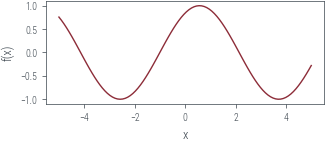

In [273]:
# Plot
f = lambda x: torch.sin(x + 1)

x = torch.linspace(-5, 5, 100)
plt.plot(x, f(x))
plt.xlabel("x")
plt.ylabel("f(x)")
plt_show("sin")


In [274]:
def get_taylor_1d_fn(f, x, a, ord):
    term = f(a).repeat(x.size())
    poly = r"$\tilde{f}(x) = $" + f"{f(a).item():.2f}"
    for i in range(1, ord + 1):
        f = grad(f)
        value = f(a)
        value_str = f"{abs(value.item()):.2f}"
        denominator = factorial(i)
        poly_term = f"(x - {a.item():.2f})^{i}"
        term = term + value * (x - a) ** i / denominator
        if i <= 5:
            poly += (
                f"{' - ' if value < 0 else ' + '}"
                + value_str
                + r"$\frac{"
                + poly_term
                + "}{"
                + f"{i}!"
                + "}"
                + "$"
            )
        elif i == 6:
            poly += " + ..."
    return term.detach().numpy(), poly

In [275]:
@interact(ord=(0, 12))
def plot_1d_taylor(ord):
    plt.plot(x, f(x), label="f(x)")
    term, poly = get_taylor_1d_fn(f, x, a=torch.tensor(0.0), ord=ord)
    plt.plot(
        x,
        term,
        # get_taylor_1d_fn(f, x, a=torch.tensor(0.0), ord=ord),
        label=f"Taylor aproximation\nPolynomial degree: {ord}",
        linestyle="--",
    )
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.title(poly)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.ylim(-1.5, 1.5)
    plt_show(f"sin-taylor-{ord}")


interactive(children=(IntSlider(value=6, description='ord', max=12), Output()), _dom_classes=('widget-interact…

## ND Taylor approximation

Checking that two times jacobian is a hessian

In [276]:
f = lambda x: torch.sin(x[0] + 1) + torch.cos(x[1] - 1)
inp = torch.tensor([1.0, 2.0])

display(jacfwd(jacfwd(f))(inp))
display(hessian(f)(inp))

tensor([[-0.9093, -0.0000],
        [-0.0000, -0.5403]])

tensor([[-0.9093,  0.0000],
        [ 0.0000, -0.5403]])

torch.Size([400, 2]) torch.Size([20, 20])


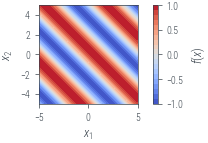

In [277]:
# define a function which is 45 degree rotated sin function
f = lambda x: torch.sin(x.sum() + 1)

x = torch.linspace(-5, 5, 20)
X1, X2 = torch.meshgrid(x, x)
X = torch.stack([X1.ravel(), X2.ravel()], dim=-1)
Y = torch.vmap(f)(X).reshape(X1.shape)
print(X.shape, Y.shape)

plt.contourf(X1, X2, Y, levels=20, vmin=-1, vmax=1, cmap="coolwarm")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.colorbar(label="$f(x)$", ticks=[-1, -0.5, 0, 0.5, 1])
plt.gca().set_aspect("equal")
plt_show("sin2d")


/home/patel_zeel/miniconda3/envs/torch_dt/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


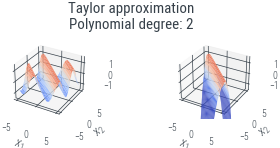

In [278]:
def nd_taylor_approx(x):
    x = x.reshape(1, -1)
    term = f(a)
    if ord >= 1:
        jacobian = jacfwd(f)(a)
        term = (term + jacobian @ (x - a).T).squeeze()
    if ord >= 2:
        hess = hessian(f)(a.ravel())
        term = term + (((x - a) @ hess @ (x - a).T) / 2).squeeze()
    if ord >= 3:
        raise NotImplementedError
    return term


nd_taylor_approx = torch.vmap(nd_taylor_approx)

ord = 2
a = torch.tensor([0.0, 0.0], dtype=torch.float64).reshape(1, 2)

T_Y = nd_taylor_approx(X).reshape(X1.shape)
fig = plt.figure()
# add a 3d axis
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X1, X2, Y, cmap="coolwarm", vmin=-1.5, vmax=1.5)
ax.set_zlim(-1.5, 1.5)
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X1, X2, T_Y, cmap="coolwarm", vmin=-1.5, vmax=1.5)
ax2.set_zlim(-1.5, 1.5)
# mappable = ax[0].contourf(X1, X2, Y.reshape(X1.shape), levels=20)
# fig.colorbar(mappable, ax=ax[0])
# mappable = ax[1].contourf(X1, X2, T_Y, levels=20, vmin=Y.min(), vmax=Y.max())
ax.set_xlabel("$x_1$", labelpad=-2)
ax2.set_xlabel("$x_1$", labelpad=-2)
ax2.set_ylabel("$x_2$", labelpad=-2)
ax.set_ylabel("$x_2$", labelpad=-2)
fig.suptitle(f"Taylor approximation\nPolynomial degree: {ord}")
plt_show(f"sin2d-taylor-{ord}")


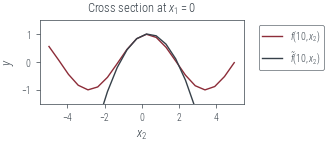

In [279]:
plt.plot(x, Y[10, :], label="$f(10, x_2)$")
plt.plot(x, T_Y[10, :], label=r"$\tilde{{f}}(10, x_2)$")
plt.ylim(-1.5, 1.5)
plt.xlabel("$x_2$")
plt.ylabel("$y$")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Cross section at $x_1 = 0$")
plt_show(f"sin2d-taylor-1d-{ord}")

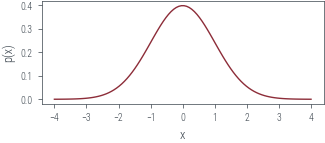

In [280]:
# Simple PDF approximation and assume it to be our prob function
p = torch.distributions.Normal(0, 1)

logp = lambda x: p.log_prob(x)

# Plot
x = torch.linspace(-4, 4, 100)
plt.plot(x, logp(x).exp())
plt.xlabel("x")
plt.ylabel("p(x)")
plt_show("standard-normal")


## Beta prior for coin toss

In [281]:
data = torch.tensor([1] * 9 + [0] * 1, dtype=torch.float64)
alpha = 2
beta = 2


def neg_log_prior(theta):
    return -dist.Beta(alpha, beta).log_prob(theta)


def neg_log_likelihood(theta):
    likelihood = torch.where(data == 1, torch.log(theta), torch.log(1 - theta))
    return -likelihood.sum()


def neg_log_joint(theta):
    return neg_log_prior(theta) + neg_log_likelihood(theta)

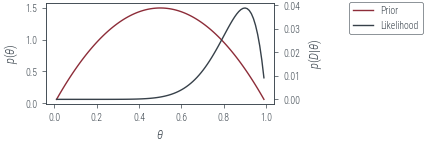

In [282]:
theta_grid = torch.linspace(0.01, 0.99, 100)


def plot_prior_and_lik():
    prior = torch.exp(-neg_log_prior(theta_grid))
    fig, ax = plt.subplots()
    ax.plot(theta_grid, prior, label="Prior", color="C0")
    twinx = ax.twinx()
    twinx.plot(
        theta_grid,
        torch.exp(-torch.vmap(neg_log_likelihood)(theta_grid)),
        label="Likelihood",
        color="C1",
    )
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$p(\theta)$")
    twinx.set_ylabel(r"$p(D|\theta)$")
    return fig, ax, twinx


fig, ax, twinx = plot_prior_and_lik()
fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("beta-prior-coin-toss")


loss=3.61: 100%|██████████| 500/500 [00:00<00:00, 588.95it/s]


tensor(0.8333, requires_grad=True)


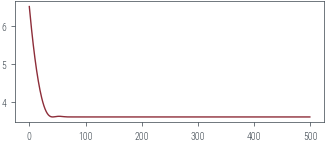

In [283]:
theta_map = torch.tensor(0.5, requires_grad=True)


def optimize(theta, epochs, lr):
    optimizer = torch.optim.Adam([theta], lr=lr)

    pbar = tqdm(range(epochs))
    losses = []
    for epoch in pbar:
        optimizer.zero_grad()
        loss = neg_log_joint(theta)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss={loss.item():.2f}")
        losses.append(loss.item())
    return losses


losses = optimize(theta_map, epochs=500, lr=0.01)
print(theta_map)
plt.plot(losses)
plt.show()

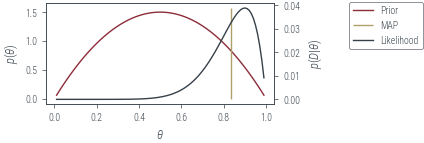

In [284]:
fig, ax, twinx = plot_prior_and_lik()
with torch.no_grad():
    ax.vlines(theta_map.item(), *ax.get_ylim(), label="MAP", color="C2")

fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("beta-prior-coin-toss-map")

In [285]:
hess = hessian(neg_log_joint)(theta_map)
posterior_variance = 1 / hess
approx_posterior = dist.Normal(theta_map, posterior_variance**0.5)

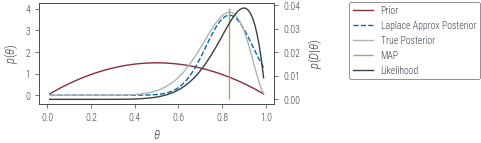

In [286]:
true_posterior = dist.Beta(alpha + data.sum(), beta + len(data) - data.sum())
fig, ax, twinx = plot_prior_and_lik()
with torch.no_grad():
    ax.plot(
        theta_grid,
        torch.exp(approx_posterior.log_prob(theta_grid)),
        label="Laplace Approx Posterior",
        color="C3",
        linestyle="--",
    )
    ax.plot(
        theta_grid,
        torch.exp(true_posterior.log_prob(theta_grid)),
        label="True Posterior",
        color="C4",
    )
    ax.vlines(theta_map.item(), *ax.get_ylim(), label="MAP", color="C2")

fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("beta-prior-coin-toss-laplace")

## Normal prior for coin toss

In [287]:
data = torch.tensor([1] * 9 + [0] * 1, dtype=torch.float64)
prior_mean = torch.tensor(-2.0)
prior_variance = torch.tensor(1.0)


def neg_log_prior(theta):
    return -dist.Normal(prior_mean, prior_variance**0.5).log_prob(theta).squeeze()


def neg_log_likelihood(theta):
    preds = torch.sigmoid(theta)
    likelihood = torch.where(data == 1, torch.log(preds), torch.log(1 - preds))
    return -likelihood.sum()


def neg_log_joint(theta):
    return neg_log_prior(theta) + neg_log_likelihood(theta)


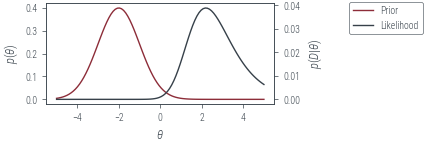

In [288]:
theta_grid = torch.linspace(-5, 5, 100)
fig, ax, twinx = plot_prior_and_lik()
fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("normal-prior-coin-toss")

loss=9.28: 100%|██████████| 500/500 [00:00<00:00, 666.91it/s] 


tensor(0.5143, requires_grad=True)


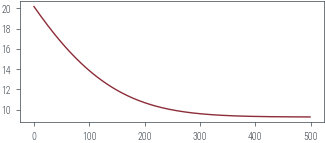

In [289]:
theta_map = torch.tensor(-2.0, requires_grad=True)
losses = optimize(theta_map, epochs=500, lr=0.01)

print(theta_map)
plt.plot(losses)
plt.show()


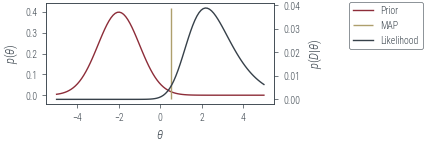

In [290]:
fig, ax, twinx = plot_prior_and_lik()
with torch.no_grad():
    ax.vlines(theta_map.item(), *ax.get_ylim(), label="MAP", color="C2")

fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("normal-prior-coin-toss-map")

In [291]:
hess = hessian(neg_log_joint)(theta_map)
posterior_variance = 1 / hess
approx_posterior = dist.Normal(theta_map, posterior_variance**0.5)


torch.Size([100])


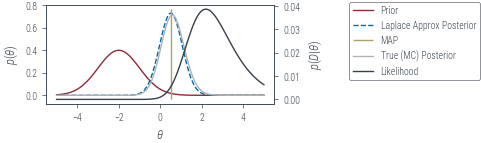

In [292]:
fig, ax, twinx = plot_prior_and_lik()
with torch.no_grad():
    ax.plot(
        theta_grid,
        torch.exp(approx_posterior.log_prob(theta_grid)),
        label="Laplace Approx Posterior",
        color="C3",
        linestyle="--",
    )
    ax.vlines(theta_map.item(), *ax.get_ylim(), label="MAP", color="C2")

# monte carlo estimation of posterior
unnorm_p = torch.exp(-torch.stack([neg_log_joint(theta) for theta in theta_grid]))
print(unnorm_p.shape)

prior = dist.Normal(prior_mean, prior_variance**0.5)
samples = prior.sample((100000,))
lik = torch.exp(-torch.vmap(neg_log_likelihood)(samples))
approx_evidence = lik.mean()
norm_p = unnorm_p / approx_evidence

ax.plot(theta_grid, norm_p, label="True (MC) Posterior", color="C4")

fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("normal-prior-coin-toss-laplace")


## Multi-Mode

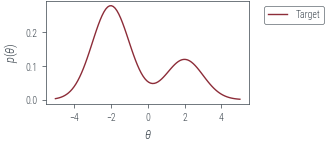

In [293]:
target = dist.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([0.7, 0.3])),
    dist.Normal(torch.tensor([-2.0, 2.0]), torch.tensor([1.0, 1.0])),
)

plt.plot(theta_grid, torch.exp(target.log_prob(theta_grid)), label="Target")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("mixture-density")

loss=1.28: 100%|██████████| 500/500 [00:00<00:00, 685.20it/s]


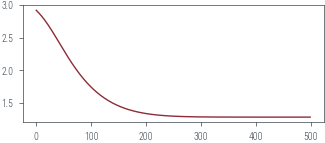

In [294]:
neg_log_joint = lambda x: -target.log_prob(x)
theta_map = torch.tensor(0.0, requires_grad=True)
losses = optimize(theta_map, epochs=500, lr=0.01)
plt.plot(losses)

In [295]:
hess = hessian(neg_log_joint)(theta_map)
posterior_variance = 1 / hess
approx_posterior = dist.Normal(theta_map, posterior_variance**0.5)


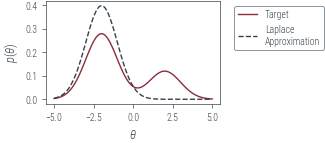

In [296]:
plt.plot(theta_grid, torch.exp(target.log_prob(theta_grid)), label="Target")
with torch.no_grad():
    plt.plot(
        theta_grid,
        torch.exp(approx_posterior.log_prob(theta_grid)),
        label="Laplace\nApproximation",
        linestyle="--",
    )
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt_show("mixture-density-laplace")

## Old

In [297]:
# Optimize logp using SGD
theta = torch.tensor(4.0, requires_grad=True)
optimizer = torch.optim.AdamW([theta], lr=0.01)

for i in range(2000):
    optimizer.zero_grad()
    loss = -logp(theta)
    if i % 100 == 0:
        print(i, theta.item(), loss.item())
    loss.backward()
    optimizer.step()

0 4.0 8.918938636779785
100 3.0124826431274414 5.4564642906188965
200 2.1752238273620605 3.284738063812256
300 1.497883915901184 2.040766716003418
400 0.9779170751571655 1.397099494934082
500 0.6023826003074646 1.1003708839416504
600 0.3488367199897766 0.9797820448875427
700 0.18942442536354065 0.9368793368339539
800 0.09626010805368423 0.9235715270042419
900 0.045690640807151794 0.9199823141098022
1000 0.02021404542028904 0.9191428422927856
1100 0.008314372971653938 0.9189730882644653
1200 0.003170008771121502 0.9189435243606567
1300 0.0011164519237354398 0.9189391136169434
1400 0.0003617757756728679 0.9189385771751404
1500 0.00010737218690337613 0.9189385175704956
1600 2.9038295906502753e-05 0.9189385175704956
1700 7.114796062523965e-06 0.9189385175704956
1800 1.5690019381509046e-06 0.9189385175704956
1900 3.091245162067935e-07 0.9189385175704956


In [298]:
theta_map = theta.detach()
theta_map


tensor(5.3954e-08)

In [299]:
plt.plot(x, p.log_prob(x).exp(), label="True PDF")

# Plot theta_map point
plt.scatter(
    0,
    p.log_prob(theta_map).exp(),
    label=r"$\theta_\textrm{MAP}$",
    color="C1",
    zorder=10,
)
plt.legend()

Error in callback <function _draw_all_if_interactive at 0x7f208ecb9d30> (for post_execute):


ValueError: 
\theta_\textrm{MAP}
       ^
ParseSyntaxException: Expected token, found '\'  (at char 7), (line:1, col:8)

ValueError: 
\theta_\textrm{MAP}
       ^
ParseSyntaxException: Expected token, found '\'  (at char 7), (line:1, col:8)

<Figure size 330.709x148.819 with 1 Axes>

In [ ]:
hessian = F.hessian(logp, theta_map)
hessian


tensor(-1.)

In [ ]:
scale = 1 / torch.sqrt(-hessian)
scale

tensor(1.)

In [ ]:
# Approximate the PDF using the Laplace approximation
approx_p = dist.Normal(theta_map, scale)
approx_p

Normal(loc: 5.395416025066879e-08, scale: 1.0)

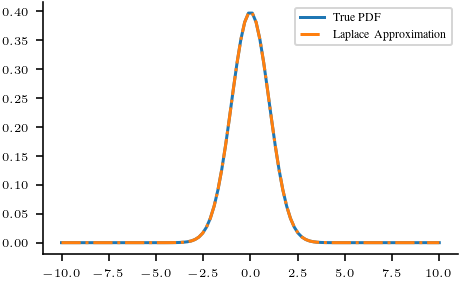

In [ ]:
# Plot original PDF
x = torch.linspace(-10, 10, 100)
plt.plot(x, p.log_prob(x).exp(), label="True PDF")
# Plot Laplace approximation
plt.plot(x, approx_p.log_prob(x).exp(), label="Laplace Approximation", linestyle="-.")
plt.legend()

In [ ]:
def laplace_approximation(logp, theta_init, lr=0.01, n_iter=2000):
    # Optimize logp using an optimizer
    theta = torch.tensor(theta_init, requires_grad=True)
    optimizer = torch.optim.AdamW([theta], lr=lr)
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -logp(theta)
        loss.backward()
        optimizer.step()
    theta_map = theta.detach()
    hessian = F.hessian(logp, theta_map)
    scale = 1 / torch.sqrt(-hessian)
    return dist.Normal(theta_map, scale)


In [ ]:
def plot_orig_approx(logp, approx_p, min_x=-10, max_x=10):
    # Plot original PDF
    x = torch.linspace(min_x, max_x, 500)
    plt.plot(x, p.log_prob(x).exp(), label="True PDF")
    # Plot Laplace approximation
    plt.plot(
        x, approx_p.log_prob(x).exp(), label="Laplace Approximation", linestyle="-."
    )
    plt.legend()

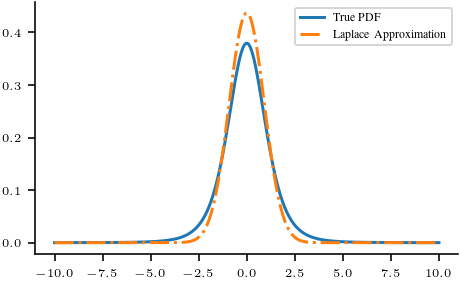

In [ ]:
# Create a Student's t-distribution
p = dist.StudentT(5, 0, 1)
logp = lambda x: p.log_prob(x)

approx_p = laplace_approximation(logp, 4.0)
plot_orig_approx(logp, approx_p)


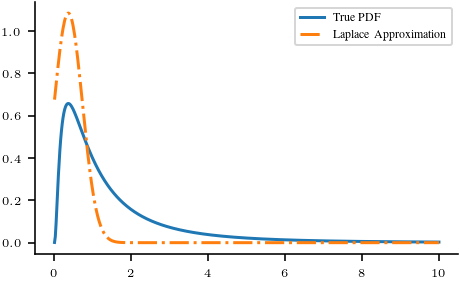

In [ ]:
p = dist.LogNormal(0, 1)
logp = lambda x: p.log_prob(x)

approx_p = laplace_approximation(logp, 4.0)
plot_orig_approx(logp, approx_p, min_x=0.01)


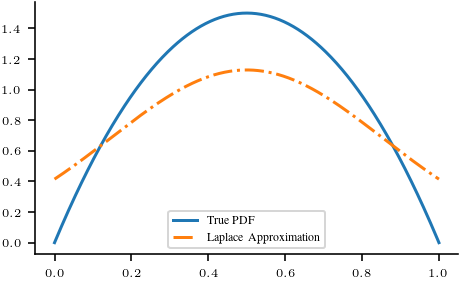

In [ ]:
p = dist.Beta(2, 2)
logp = lambda x: p.log_prob(x)

approx_p = laplace_approximation(logp, 0.5)
plot_orig_approx(logp, approx_p, min_x=0, max_x=1)
